# Modeling the X-ray image data

In [11]:
import astropy.io.fits as pyfits
import astropy.visualization as viz
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [45]:
imfits = pyfits.open('a1835_xmm/P0098010101M2U009IMAGE_3000.FTZ')
im = imfits[0].data
bkfits = pyfits.open('a1835_xmm/P0098010101M2X000BKGMAP3000.FTZ')
bk = bkfits[0].data
exfits = pyfits.open('a1835_xmm/P0098010101M2U009EXPMAP3000.FTZ')
ex = exfits[0].data

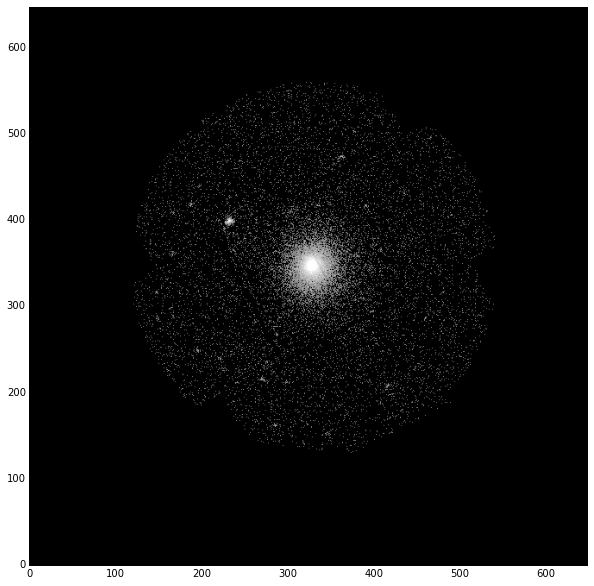

In [26]:
plt.imshow(viz.scale_image(im, scale='log', max_cut=40), cmap='gray', origin='lower');

There are non-cluster sources in this field. To simplify our lives, we will crudely mask them out before fitting anything. A convenient way to do this is by setting the exposure map to zero in these locations, since we will not consider such pixels as part of the image data.

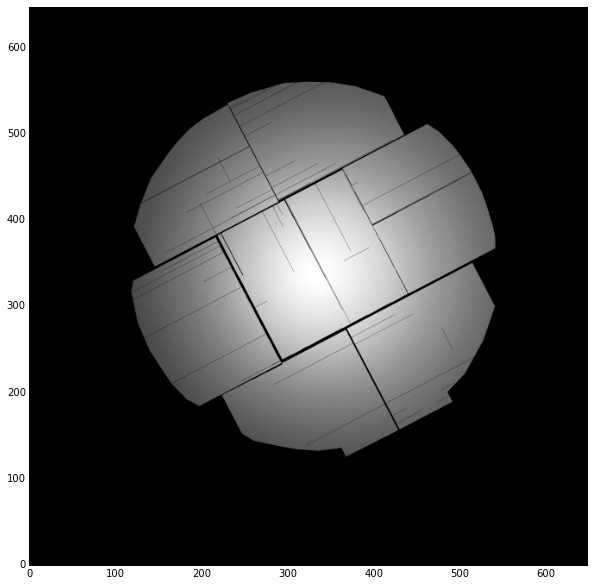

In [42]:
plt.imshow(viz.scale_image(ex), cmap='gray', origin='lower');

In [46]:
mask = np.loadtxt('a1835_xmm/M2ptsrc.txt')
for reg in mask:
    for i in np.round(reg[1]+np.arange(-np.ceil(reg[2]),np.ceil(reg[2]))):
        for j in np.round(reg[0]+np.arange(-np.ceil(reg[2]),np.ceil(reg[2]))):
            if (i-reg[1])**2 + (j-reg[0])**2 <= reg[2]**2:
                ex[np.int(i-1), np.int(j-1)] = 0.0

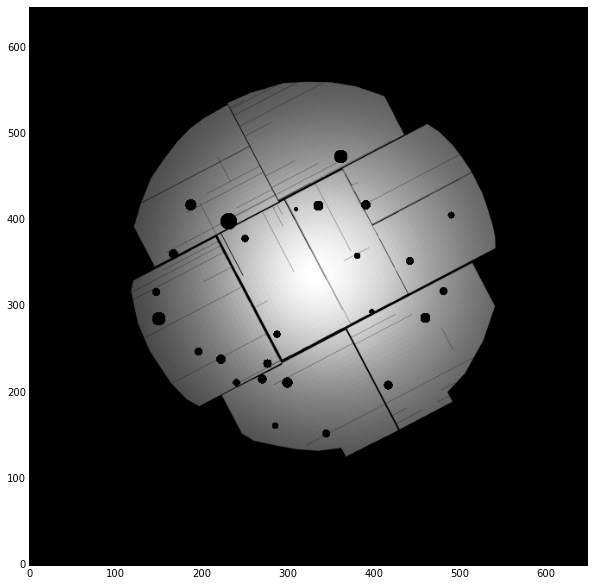

In [48]:
plt.imshow(viz.scale_image(ex), cmap='gray', origin='lower');

Finally, the background map is a theoretical model for the contribution of the particle (non-X-ray) background to the number of counts in each pixel.

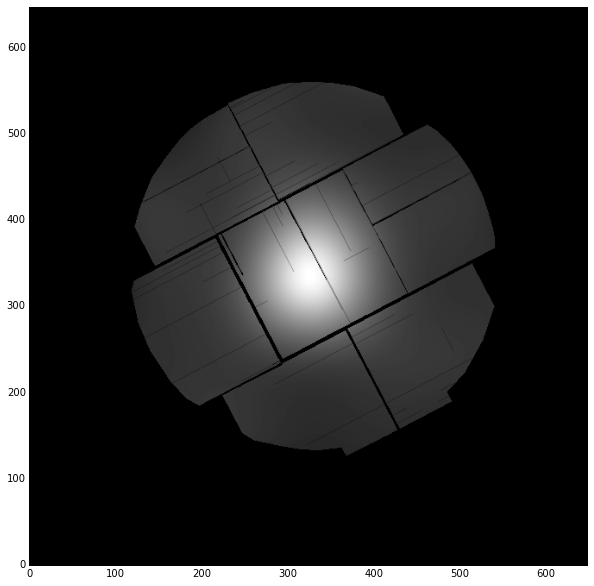

In [50]:
plt.imshow(viz.scale_image(bk), cmap='gray', origin='lower');

# TODO: build a model